### 10 Year Mutual Fund Returns as an Indicator for Retirement

Group: Jack Boydell, Luke Werkmeister-Martin, Hayden Vaughn, Ben Jaffe, Ben Kowalski

Importing the necessary packages.

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.formula.api import ols
from statsmodels.api import qqplot
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

Reading in the csv file as a pandas DataFrame. 

In [31]:
dataframe = pd.read_csv('Mutual Funds.csv')
mutual_funds = dataframe.copy()
print(mutual_funds.head())

/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (167,171) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


  fund_symbol                                 fund_extended_name  \
0       AAAAX               DWS RREEF Real Assets Fund - Class A   
1       AAADX               Aberdeen Income Builder Fund Class A   
2       AAAGX             Thrivent Large Cap Growth Fund Class A   
3       AAAIX  American Century Strategic Allocation: Aggress...   
4       AAANX  Horizon Active Asset Allocation Fund Investor ...   

                    fund_family inception_date  \
0                           DWS     2007-07-29   
1                      Aberdeen     2011-12-29   
2                Thrivent Funds     1999-10-28   
3  American Century Investments     2000-07-31   
4           Horizon Investments     2012-01-30   

                         category  rating  return_rating  risk_rating  \
0                World Allocation     3.0            3.0          3.0   
1  Allocation - 50% to 70% Equity     4.0            5.0          5.0   
2                    Large Growth     3.0            3.0          4.0  

Selecting only the colunms needed for analysis while also dropping any duplicates or rows with missing values in our subsetted dataframe. Shape attrributes before and after cleaning are compared. 

In [3]:
# only selecting columns from the dataset that will  be used in analysis
mutual_funds = mutual_funds[['fund_symbol', 'fund_extended_name', 'fund_family', 'inception_date', 'category', 'rating', 'return_rating', 'risk_rating', 'investment_strategy', 'investment_type', 'size_type','sector_basic_materials','sector_consumer_cyclical', 'sector_financial_services', 'sector_real_estate', 'sector_consumer_defensive', 'sector_healthcare', 'sector_utilities', 'sector_communication_services', 'sector_energy', 'sector_industrials','sector_technology', 'fund_yield', 'fund_return_ytd', 'fund_return_10years']]
print(f'Dimensions before cleaning: {mutual_funds.shape}')

#checking for and dropping duplicates and missing values
mutual_funds = mutual_funds.drop_duplicates()
mutual_funds = mutual_funds.dropna()

print(f'Dimensions after cleaning: {mutual_funds.shape}')

Dimensions before cleaning: (24821, 25)
Dimensions after cleaning: (13049, 25)


Creating customary Low, Medium, and High bins for each sector of the economy feature.

In [4]:
cut_bins = [-1, 10, 20, 100]
cut_labels = ["Low", "Medium", "High"]

#Binning the different sectors
mutual_funds["basic_materials_bin"]= pd.cut(mutual_funds['sector_basic_materials'],
                                          bins= cut_bins, labels= cut_labels)

mutual_funds["consumer_cyclical_bin"]= pd.cut(mutual_funds['sector_consumer_cyclical'],
                                          bins= cut_bins, labels= cut_labels)

mutual_funds["financial_services_bin"]= pd.cut(mutual_funds['sector_financial_services'],
                                          bins= cut_bins, labels= cut_labels)

mutual_funds["real_estate_bin"]= pd.cut(mutual_funds['sector_real_estate'],
                                          bins= cut_bins, labels= cut_labels)

mutual_funds["consumer_defensive_bin"]= pd.cut(mutual_funds['sector_consumer_defensive'],
                                          bins= cut_bins, labels= cut_labels)

mutual_funds["healthcare_bin"]= pd.cut(mutual_funds['sector_healthcare'],
                                          bins= cut_bins, labels= cut_labels)

mutual_funds["utilities_bin"]= pd.cut(mutual_funds['sector_utilities'],
                                          bins= cut_bins, labels= cut_labels)

mutual_funds["communication_services_bin"]= pd.cut(mutual_funds['sector_communication_services'],
                                          bins= cut_bins, labels= cut_labels)

mutual_funds["energy_bin"]= pd.cut(mutual_funds['sector_energy'],
                                          bins= cut_bins, labels= cut_labels)

mutual_funds["industrials_bin"]= pd.cut(mutual_funds['sector_industrials'],
                                          bins= cut_bins, labels= cut_labels)

mutual_funds["technology_bin"]= pd.cut(mutual_funds['sector_technology'],
                                          bins= cut_bins, labels= cut_labels)

### EDA and Stratified Sampling

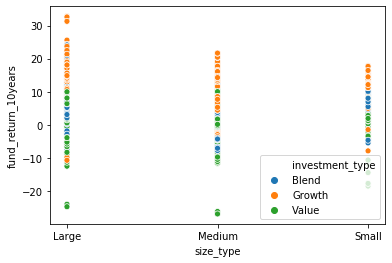

In [5]:
sns.scatterplot(x='size_type', y ='fund_return_10years', data=mutual_funds, hue ='investment_type')

Side by side boxplot created to visualize distribution of each investment type in regards to 10 year mutual fund returns. 

Text(0, 0.5, '10 Year Mutual Fund Returns (%)')

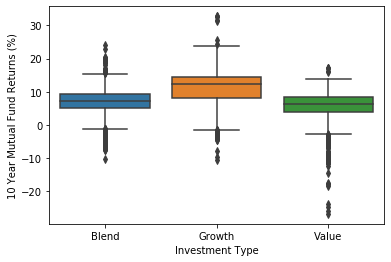

In [6]:
sns.boxplot(x='investment_type', y='fund_return_10years', data = mutual_funds)
plt.xlabel('Investment Type')
plt.ylabel('10 Year Mutual Fund Returns (%)')

Stratified sampling by investment type (n=3000 in each strata) using groupby method of pandas Dataframe with random state set to 1 for reproducibilty. Separating the full sample DataFrame by investment type to be able to access each: Growth, Value, Blend. 

In [7]:
n_sample = 3000 #how many of each of three investment types we want
full_sample_df = mutual_funds.groupby('investment_type').apply(lambda x: x.sample(n_sample, random_state=1))
full_sample_df.head(3001)

#splitting up full dataframe sample by three investment types 
mutual_funds_Value = full_sample_df[full_sample_df['investment_type'] == 'Value']
mutual_funds_Growth = full_sample_df[full_sample_df['investment_type'] == 'Growth']
mutual_funds_Blend = full_sample_df[full_sample_df['investment_type'] == 'Blend']

Splitting each investment type strata dataset into testing (25%) and training (75%) using function from sklearn. Random state set to 1 for reproducibility. 

In [8]:
# splitting each stratified sample data frame into testing/training sets
test_set_proportion = 0.25

# random state set to 1 for reproducibility
Value_train, Value_test = train_test_split(mutual_funds_Value, test_size = test_set_proportion, random_state=1)
Growth_train, Growth_test = train_test_split(mutual_funds_Growth, test_size = test_set_proportion, random_state=1)
Blend_train, Blend_test = train_test_split(mutual_funds_Blend, test_size = test_set_proportion, random_state=1)

### Growth

Feature Selection using Pearson Correlation: Visualizing variable correlations with fund_return_10years using Seaborn heatmap. 

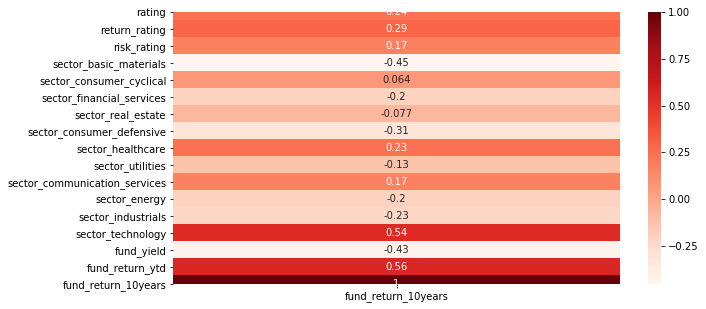

In [9]:
#Using Pearson Correlation
plt.figure(figsize=(10,5)) #(changed from (12,10))
cor = mutual_funds_Growth.corr()
response_column = pd.DataFrame(cor['fund_return_10years'])
sns.heatmap(response_column, annot=True, cmap=plt.cm.Reds)
plt.show()

Selecting the two sectors most correlated with 10 year mutual fund returns by setting correlation target to 0.4.

In [10]:
#Correlation with output variable
cor_target = abs(cor["fund_return_10years"]) # absolute value
#Selecting highly correlated features
relevant_features = cor_target[cor_target>0.4]
relevant_features

sector_basic_materials    0.453395
sector_technology         0.544251
fund_yield                0.426123
fund_return_ytd           0.557175
fund_return_10years       1.000000
Name: fund_return_10years, dtype: float64

Checking to ensure that our two selected features of sector_technology and sector_basic_materials are not highly correlated with each other.

In [11]:
print(mutual_funds_Growth[["sector_basic_materials","sector_technology"]].corr()) # low correlation with each other so they are independent

                        sector_basic_materials  sector_technology
sector_basic_materials                1.000000          -0.294865
sector_technology                    -0.294865           1.000000


Simple linear regression model using basic materials sector as variable. 

                             OLS Regression Results                            
Dep. Variable:     fund_return_10years   R-squared:                       0.207
Model:                             OLS   Adj. R-squared:                  0.207
Method:                  Least Squares   F-statistic:                     588.1
Date:                 Sat, 18 Dec 2021   Prob (F-statistic):          1.33e-115
Time:                         14:48:03   Log-Likelihood:                -6366.1
No. Observations:                 2250   AIC:                         1.274e+04
Df Residuals:                     2248   BIC:                         1.275e+04
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept         

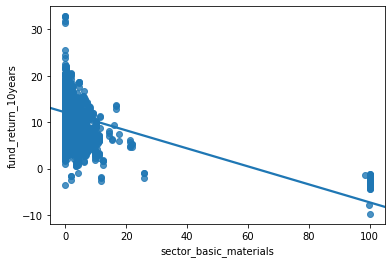

In [12]:
#simple linear regression: basic materials
basic_materials = ols('fund_return_10years ~ sector_basic_materials', data=Growth_train).fit()
print(basic_materials.summary()) 

sns.regplot(x= 'sector_basic_materials', y= 'fund_return_10years', data=mutual_funds_Growth, ci=None)

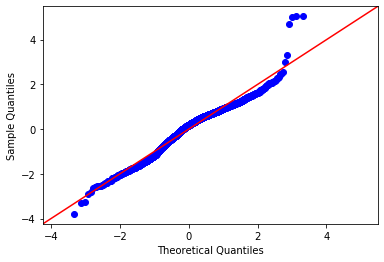

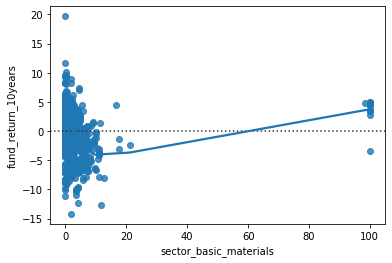

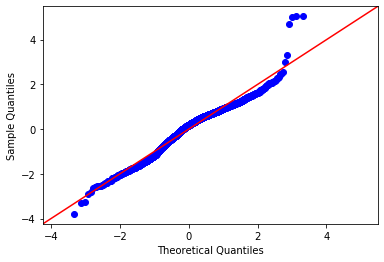

In [13]:
sns.residplot(x= 'sector_basic_materials', y= 'fund_return_10years', data=Growth_test, lowess=True)
qqplot(data = basic_materials.resid, fit=True, line='45')

Mutliple linear regression with basic materials and size type. 

                             OLS Regression Results                            
Dep. Variable:     fund_return_10years   R-squared:                       0.212
Model:                             OLS   Adj. R-squared:                  0.211
Method:                  Least Squares   F-statistic:                     201.3
Date:                 Sat, 18 Dec 2021   Prob (F-statistic):          1.29e-115
Time:                         14:48:04   Log-Likelihood:                -6359.7
No. Observations:                 2250   AIC:                         1.273e+04
Df Residuals:                     2246   BIC:                         1.275e+04
Df Model:                            3                                         
Covariance Type:             nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
size_type[Large]  

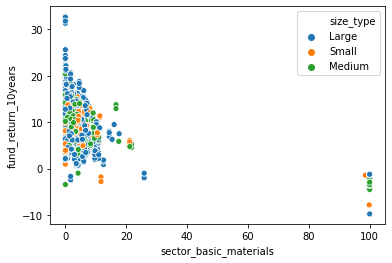

In [14]:
#multiple linear regression: basic materials + size type (small, medium, large)
basic_materials_with_size = ols('fund_return_10years ~ sector_basic_materials + size_type + 0', data=Growth_train).fit()
print(basic_materials_with_size.summary())

sns.scatterplot(x= 'sector_basic_materials', y= 'fund_return_10years', data=mutual_funds_Growth, hue='size_type')

#text

Text(0.5, 1.0, 'Residual qqplot: 10 year mutual fund returns vs. basic materials + size type')

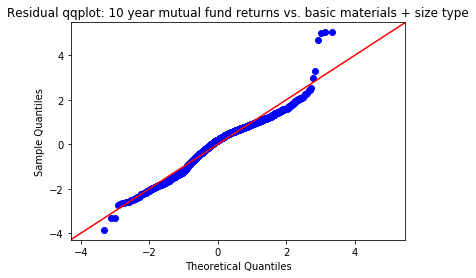

In [15]:
qqplot(data=basic_materials_with_size.resid, fit=True, line="45")
plt.title('Residual qqplot: 10 year mutual fund returns vs. basic materials + size type')

Simple linear regression model using technology sector as variable. 

                             OLS Regression Results                            
Dep. Variable:     fund_return_10years   R-squared:                       0.301
Model:                             OLS   Adj. R-squared:                  0.301
Method:                  Least Squares   F-statistic:                     969.8
Date:                 Sat, 18 Dec 2021   Prob (F-statistic):          2.56e-177
Time:                         14:48:05   Log-Likelihood:                -6224.1
No. Observations:                 2250   AIC:                         1.245e+04
Df Residuals:                     2248   BIC:                         1.246e+04
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             6.1357

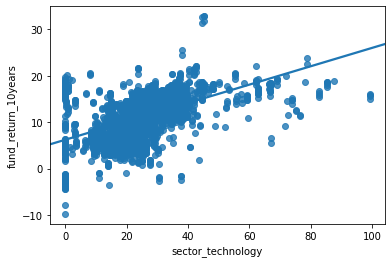

In [16]:
#linear regression model testing: technology
technology_model = ols('fund_return_10years ~ sector_technology', data=Growth_train).fit()
print(technology_model.summary())

sns.regplot(x= 'sector_technology', y= 'fund_return_10years', data=mutual_funds_Growth, ci=None)

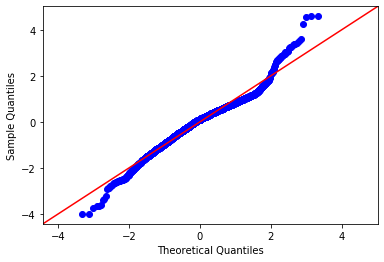

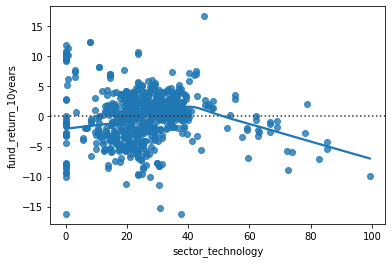

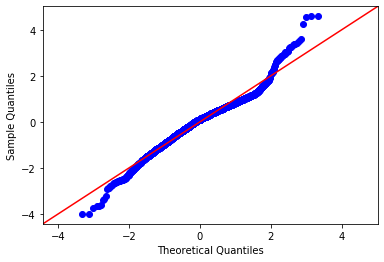

In [17]:
sns.residplot(x= 'sector_technology', y= 'fund_return_10years', data=Growth_test, lowess=True)
qqplot(data=technology_model.resid, fit=True, line="45")

Multiple linear regression model using technology sector with size. 

                             OLS Regression Results                            
Dep. Variable:     fund_return_10years   R-squared:                       0.302
Model:                             OLS   Adj. R-squared:                  0.301
Method:                  Least Squares   F-statistic:                     323.8
Date:                 Sat, 18 Dec 2021   Prob (F-statistic):          1.10e-174
Time:                         14:48:06   Log-Likelihood:                -6223.3
No. Observations:                 2250   AIC:                         1.245e+04
Df Residuals:                     2246   BIC:                         1.248e+04
Df Model:                            3                                         
Covariance Type:             nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
size_type[Large]      6.0163

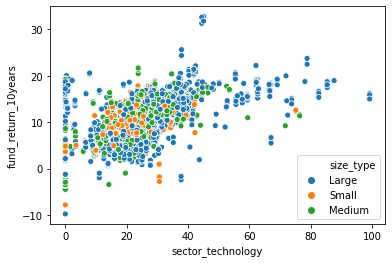

In [18]:
#multiple linear regression: technology + size type (small, medium, large)
technology_with_size = ols('fund_return_10years ~ sector_technology + size_type + 0', data=Growth_train).fit()
print(technology_with_size.summary())

sns.scatterplot(x= 'sector_technology', y= 'fund_return_10years', data=mutual_funds_Growth, hue='size_type')

Text(0.5, 1.0, 'Residual qqplot: 10 year mutual fund returns vs. technology + size type')

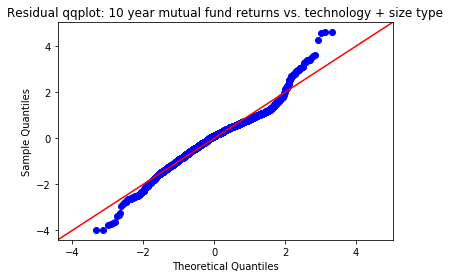

In [19]:
qqplot(data=technology_with_size.resid, fit=True, line="45")
plt.title('Residual qqplot: 10 year mutual fund returns vs. technology + size type')

In [20]:
#multiple linear regression with basic materials and technology
tech_and_bm = ols('fund_return_10years ~ sector_technology + sector_basic_materials', data=Growth_train).fit()
print(tech_and_bm.summary())

                             OLS Regression Results                            
Dep. Variable:     fund_return_10years   R-squared:                       0.395
Model:                             OLS   Adj. R-squared:                  0.394
Method:                  Least Squares   F-statistic:                     733.6
Date:                 Sat, 18 Dec 2021   Prob (F-statistic):          6.15e-246
Time:                         14:48:08   Log-Likelihood:                -6062.2
No. Observations:                 2250   AIC:                         1.213e+04
Df Residuals:                     2247   BIC:                         1.215e+04
Df Model:                            2                                         
Covariance Type:             nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept         

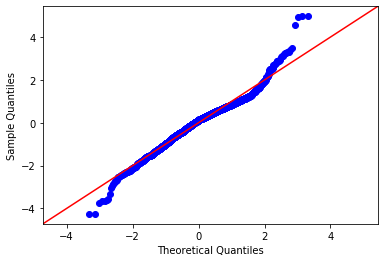

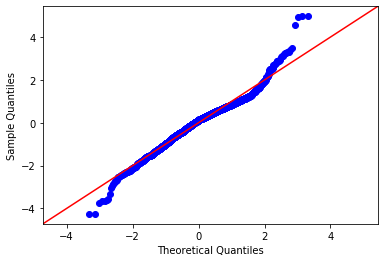

In [21]:
qqplot(data=tech_and_bm.resid, fit=True, line="45")

### Value

Feature Selection using Pearson Correlation: Visualizing variable correlations with fund_return_10years using Seaborn heatmap. 

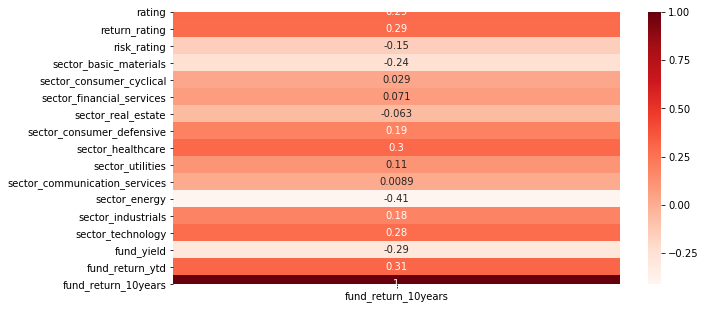

In [22]:
#Using Pearson Correlation
plt.figure(figsize=(10,5)) #(changed from (12,10))
cor = mutual_funds_Value.corr()
response_column = pd.DataFrame(cor['fund_return_10years'])
sns.heatmap(response_column, annot=True, cmap=plt.cm.Reds)
plt.show()

Selecting the two sectors most correlated with 10 year mutual fund returns by setting correlation target to 0.3.

In [23]:
#Correlation with output variable
cor_target = abs(cor["fund_return_10years"]) # absolute value
#Selecting highly correlated features
relevant_features = cor_target[cor_target>0.295]
relevant_features

sector_healthcare      0.295136
sector_energy          0.410647
fund_return_ytd        0.308930
fund_return_10years    1.000000
Name: fund_return_10years, dtype: float64

Checking to ensure that our two selected features of sector_energy and sector_healthcare are not highly correlated with each other.

In [24]:
print(mutual_funds_Value[["sector_energy","sector_healthcare"]].corr()) # low correlation with each other so they are independent

                   sector_energy  sector_healthcare
sector_energy           1.000000          -0.272837
sector_healthcare      -0.272837           1.000000


Mutiple linear regression model using energy sector and size. 

                             OLS Regression Results                            
Dep. Variable:     fund_return_10years   R-squared:                       0.159
Model:                             OLS   Adj. R-squared:                  0.157
Method:                  Least Squares   F-statistic:                     141.1
Date:                 Sat, 18 Dec 2021   Prob (F-statistic):           9.63e-84
Time:                         14:48:13   Log-Likelihood:                -5913.7
No. Observations:                 2250   AIC:                         1.184e+04
Df Residuals:                     2246   BIC:                         1.186e+04
Df Model:                            3                                         
Covariance Type:             nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
size_type[Large]      6.7726

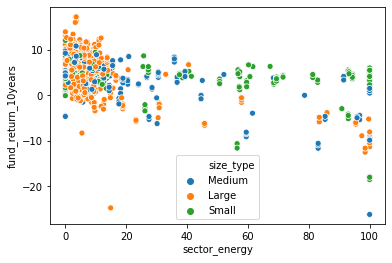

In [25]:
#multiple linear regression model testing
energy_with_size = ols('fund_return_10years ~ sector_energy + size_type + 0', data=Value_train).fit()
print(energy_with_size.summary())

sns.scatterplot(x= 'sector_energy', y= 'fund_return_10years', data=mutual_funds_Value, hue='size_type')

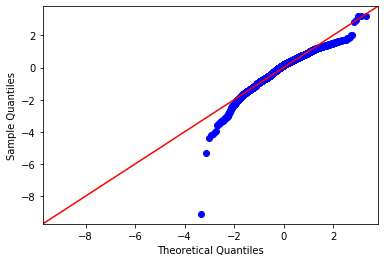

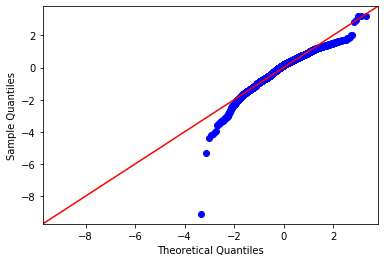

In [26]:
qqplot(data=energy_with_size.resid, fit=True, line="45")

Mutiple linear regression model using healthcare sector and size. 

                             OLS Regression Results                            
Dep. Variable:     fund_return_10years   R-squared:                       0.086
Model:                             OLS   Adj. R-squared:                  0.085
Method:                  Least Squares   F-statistic:                     70.57
Date:                 Sat, 18 Dec 2021   Prob (F-statistic):           1.30e-43
Time:                         14:48:14   Log-Likelihood:                -6006.6
No. Observations:                 2250   AIC:                         1.202e+04
Df Residuals:                     2246   BIC:                         1.204e+04
Df Model:                            3                                         
Covariance Type:             nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
size_type[Large]      5.1578

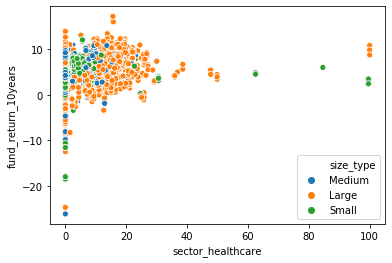

In [27]:
#multiple linear regression model testing
healthcare_with_size = ols('fund_return_10years ~ sector_healthcare + size_type + 0', data=Value_train).fit()
print(healthcare_with_size.summary())

sns.scatterplot(x= 'sector_healthcare', y= 'fund_return_10years', data=mutual_funds_Value, hue='size_type')

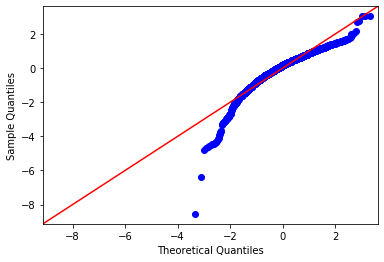

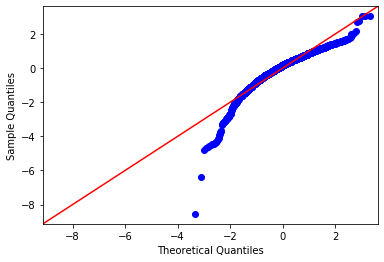

In [28]:
qqplot(data=healthcare_with_size.resid, fit=True, line="45")

In [29]:
# Checking predictions/residuals

predicted_returns_energy_large = practice_model1.predict(Value_test)
predicted_returns_energy_large.head()

NameError: name 'practice_model1' is not defined

### Blend

Feature Selection using Pearson Correlation: Visualizing variable correlations with fund_return_10years using Seaborn heatmap. 

In [ ]:
#Using Pearson Correlation
plt.figure(figsize=(12,10)) #(changed from (12,10))
cor = mutual_funds_Blend.corr()
response_column = pd.DataFrame(cor['fund_return_10years'])
sns.heatmap(response_column, annot=True, cmap=plt.cm.Reds)
plt.show()

Selecting the two sectors most correlated with 10 year mutual fund returns by setting correlation target to 0.3.

In [ ]:
#Correlation with output variable
cor_target = abs(cor["fund_return_10years"]) # absolute value
#Selecting highly correlated features
relevant_features = cor_target[cor_target>0.3]
relevant_features

In [ ]:
print(mutual_funds_Blend[["sector_basic_materials","sector_technology"]].corr()) # low correlation with each other so they are independent

Mutiple linear regression model using healthcare sector and size. 

In [ ]:
#initial linear regression model testing
B_healthcare_with_size = ols('fund_return_10years ~ sector_healthcare + size_type + 0', data=Blend_train).fit()
print(B_healthcare_with_size.summary())

sns.scatterplot(x= 'sector_healthcare', y= 'fund_return_10years', data=mutual_funds_Blend, hue='size_type')

In [ ]:
qqplot(data=B_healthcare_with_size.resid, fit=True, line="45")

Mutiple linear regression model using basic materials sector and size. 

In [ ]:
#initial linear regression model testing
B_bm_with_size = ols('fund_return_10years ~ sector_basic_materials + size_type + 0', data=Blend_train).fit()
print(B_bm_with_size.summary())

#checking residuals (manually) for model predicitng in test set
#pred = practice_model.predict(Blend_test['sector_basic_materials'])
#print(pred - Blend_test['fund_return_10years'])

sns.scatterplot(x= 'sector_basic_materials', y= 'fund_return_10years', data=mutual_funds_Blend, hue='size_type')

In [ ]:
qqplot(data=B_bm_with_size.resid, fit=True, line="45")

Mutiple linear regression model using technology sector and size. 

In [ ]:
#initial linear regression model testing
B_technology_with_size = ols('fund_return_10years ~ sector_technology + size_type + 0', data=Blend_train).fit()
print(B_technology_with_size.summary())

#checking residuals (manually) for model predicitng in test set
#pred = practice_model.predict(Blend_test['sector_basic_materials'])
#print(pred - Blend_test['fund_return_10years'])

sns.scatterplot(x= 'sector_technology', y= 'fund_return_10years', data=mutual_funds_Blend, hue='size_type')

In [ ]:
qqplot(data=practice_model_technology.resid, fit=True, line="45")